In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/birds/src


## Initialization

### Imports

In [3]:
import re
import gc
import os
import time
import pickle
import random
import operator
import datetime
import soundfile
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn.model_selection import *

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.model_zoo as model_zoo

from torch import Tensor
from torch.optim import *
from audiomentations import *
from torch.nn.modules.loss import *
from torch.optim.lr_scheduler import * 
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader

In [51]:
from util import *
from params import *
from training.train import predict
from model_zoo.models import get_model

## Data

### Loading

In [5]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')

In [6]:
paths = []
for c, file in df_train[['ebird_code', 'filename']].values:
    path = f"{c}/{file[:-4]}.wav"
    paths.append(path)
    
df_train['file_path'] = paths

### Audio parameters

In [7]:
class AudioParams:
    sr = 32000
    duration = 5
    img_size = None

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = 16000
    
    n_fft = n_mels * 20 # Size of fft window - smooths the spectrogram
    
    spec_width = 256
    hop_length = duration * sr // spec_width + 1   # Computed to have width=spec_width

### Dataset

In [8]:
from data.transforms import *
from data.dataset import *

class ClipDataset(Dataset):
    def __init__(self, clip, params):
        self.clip = clip
        self.params = params
        
        self.starts = [i for i in range(len(clip) // sr - 5)]
        
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        start_index = self.starts[idx] * self.params.sr
        end_index = start_index + self.params.sr * 5

        y = self.clip[start_index:end_index].astype(np.float32)

        melspec = compute_melspec(y, self.params)
        
        image = mono_to_color(melspec)
        image = resize(image, self.params.img_size)
        image = normalize(image, mean=None, std=None)
        
        
        return image, 0

In [9]:
path = df_train['file_path'][0]
clip, sr = soundfile.read(AUDIO_PATH + path)

In [10]:
dataset = ClipDataset(clip, AudioParams)

In [11]:
x, y = dataset[19]

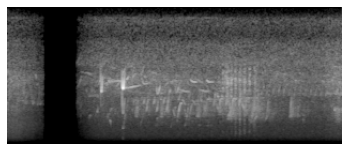

In [12]:
plt.imshow(x.transpose(1, 2, 0))
plt.axis(False)
plt.show()

In [13]:
x.shape

(3, 128, 313)

# Training

In [21]:
def inference(model, df):
    pred_dic = {}
    for path in tqdm(df['file_path']):
        clip, sr = soundfile.read(AUDIO_PATH + path)
        dataset = ClipDataset(clip, AudioParams)
        
        pred = predict(model, dataset)
        pred_dic[path] = pred
    return pred_dic

In [48]:
def k_fold(config, df):
    
    skf = StratifiedKFold(n_splits=config.k, random_state=config.random_state)
    splits = list(skf.split(X=df, y=df['ebird_code']))
    
    pred_oof_dic = {}

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")
            df_val = df.iloc[val_idx].copy()
            
            model = get_model(config.selected_model, num_classes=NUM_CLASSES).cuda()
            load_model_weights(model, 
                               f"{config.selected_model}_{config.name}_{i}.pt", 
                               cp_folder="../checkpoints/dataset1/",
                               verbose=1)
            model.zero_grad()

            pred_dic = inference(model, df_val)
            pred_oof_dic.update(pred_dic)

            with open(f'../output/preds_{i}.pkl', 'wb') as file:
                pickle.dump(pred_dic, file, protocol=pickle.HIGHEST_PROTOCOL)
                
    return pred_oof_dic

### Config

In [49]:
class Config:
    # General
    seed = 2020
    verbose = 1
    verbose_eval = 1
    save = True
    
    # k-fold
    k = 5
    random_state = 42
    selected_folds = [0, 1, 2, 3, 4]
    
    # Model
    selected_model = 'resnest50_fast_1s1x64d'  
#     selected_model = 'resnet34'  
#     selected_model = 'efficientnet-b0'
    
#     img_size = 256

    val_bs = 64
    
    name = "mixup5"

### Training

In [50]:
pred_oof_dic = k_fold(Config, df_train)


-------------   Fold 1 / 5  -------------


 -> Loading weights from ../checkpoints/dataset1/resnest50_fast_1s1x64d_mixup5_0.pt





-------------   Fold 2 / 5  -------------


 -> Loading weights from ../checkpoints/dataset1/resnest50_fast_1s1x64d_mixup5_1.pt





-------------   Fold 3 / 5  -------------


 -> Loading weights from ../checkpoints/dataset1/resnest50_fast_1s1x64d_mixup5_2.pt





-------------   Fold 4 / 5  -------------


 -> Loading weights from ../checkpoints/dataset1/resnest50_fast_1s1x64d_mixup5_3.pt





-------------   Fold 5 / 5  -------------


 -> Loading weights from ../checkpoints/dataset1/resnest50_fast_1s1x64d_mixup5_4.pt



In [111]:
np.random.choice(

TypeError: choice() takes at least 1 positional argument (0 given)

In [163]:
probs = [0, 0.3, 0.3, 0.3, 0.1]
int(32000 * (np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()))

115001

In [149]:
np.random.random()

0.5883796083760438

In [106]:
with open(f'../output/preds_oof.pkl', 'rb') as file:
    confidences  = pickle.load(file)

In [52]:
with open(f'../output/preds_oof.pkl', 'wb') as file:
    pickle.dump(pred_oof_dic, file, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
df_train.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,url,country,author,primary_label,longitude,length,time,recordist,license,file_path
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,aldfly/XC134874.wav
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...,aldfly/XC135454.wav
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...,aldfly/XC135455.wav
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...,aldfly/XC135456.wav
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...,aldfly/XC135457.wav


In [96]:
ONE_HOT = np.eye(NUM_CLASSES)

def f1(truth, pred, threshold=0.5):
    if len(truth.shape) == 1:
        truth = ONE_HOT[truth]

    pred = (pred > threshold).astype(int)

    return f1_score(truth, pred, average='samples')

In [102]:
f1_scores = []
preds = []
truths = []

for c, file in tqdm(df_train[['ebird_code', 'file_path']].values):
    c_ = CLASSES.index(c)
    pred = pred_oof_dic[file]

    if len(pred):
        preds.append(pred[0])
        truths.append(c_)

In [103]:
f1(np.array(truths), np.array(preds))

0.7240990422326583

In [77]:
y, sr = soundfile.read(AUDIO_PATH + file)
ipd.Audio(y, rate=sr)

In [53]:
pred_oof_dic

{'aldfly/XC134874.wav': array([[9.92640018e-01, 7.92989704e-06, 1.27492298e-04, ...,
         6.73480827e-05, 1.25019276e-03, 7.59586634e-04],
        [9.90471125e-01, 3.33944354e-06, 4.10870198e-05, ...,
         1.25776191e-04, 8.70757736e-04, 1.70040107e-03],
        [2.52198398e-01, 7.82924144e-06, 1.68503422e-04, ...,
         1.31337903e-04, 1.04089826e-02, 3.24396626e-03],
        ...,
        [9.98607934e-01, 7.75036824e-07, 1.99699032e-04, ...,
         2.33513580e-04, 1.40287229e-04, 7.61009578e-05],
        [9.93390203e-01, 5.92079516e-07, 1.08569780e-04, ...,
         2.78658583e-04, 5.41721274e-05, 8.52752346e-05],
        [9.98830974e-01, 1.59213471e-06, 3.60564940e-04, ...,
         1.02217255e-05, 5.71429555e-04, 6.19244063e-04]]),
 'aldfly/XC135454.wav': array([[9.99120057e-01, 1.16137962e-04, 6.30766517e-05, ...,
         6.77429853e-05, 1.50955544e-04, 2.65124138e-04],
        [9.97443080e-01, 1.19693163e-04, 1.04183920e-04, ...,
         7.25903301e-05, 3.09612078e-